# **Part 1: Spoof Detection**

# **Installation**

In [ ]:
!pip install torch torchvision transformers datasets opencv-python pillow matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTFeatureExtractor, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import random


# **Dataset load**

In [ ]:
# Load dataset
dataset = load_dataset("nguyenkhoa/celeba-spoof-for-face-antispoofing-test")

# Reduce dataset size to 50%
test_dataset = dataset["test"]
num_samples = len(test_dataset) // 4 # Reduce to 50%

# Randomly select 50% of the data
indices = random.sample(range(len(test_dataset)), num_samples)
reduced_dataset = test_dataset.select(indices)

# Display dataset information
print(reduced_dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/437 [00:00<?, ?B/s]

test-00000-of-00010.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

test-00001-of-00010.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

test-00002-of-00010.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

test-00003-of-00010.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

test-00004-of-00010.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

test-00005-of-00010.parquet:   0%|          | 0.00/499M [00:00<?, ?B/s]

test-00006-of-00010.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

test-00007-of-00010.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

test-00008-of-00010.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

test-00009-of-00010.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/67170 [00:00<?, ? examples/s]

Dataset({
    features: ['cropped_image', 'labels', 'labelNames'],
    num_rows: 16792
})


# **Preprocessing**

In [ ]:
from transformers import ViTImageProcessor
import torch

# Load pre-trained processor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Step 1: Remove None values before mapping
filtered_dataset = reduced_dataset.filter(lambda x: x["cropped_image"] is not None)

# Step 2: Define transformation function
def transform(example):
    image = example["cropped_image"]

    try:
        # Convert to ViT format
        image = processor(image, return_tensors="pt")["pixel_values"][0]
    except Exception as e:
        print(f"Skipping image due to error: {e}")
        return None  # Return None for failed transformations

    return {"pixel_values": image, "label": example["labels"]}

# Step 3: Apply transformation only on valid images
transformed_dataset = filtered_dataset.map(transform, remove_columns=["cropped_image", "labelNames"])

# # Step 4: Remove any remaining None values after mapping
# transformed_dataset = transformed_dataset.filter(lambda x: x["pixel_values"] is not None)

# Step 5: Verify dataset size
print(f"Final dataset size: {len(transformed_dataset)}")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Filter:   0%|          | 0/16792 [00:00<?, ? examples/s]

Map:   0%|          | 0/16691 [00:00<?, ? examples/s]

Final dataset size: 16691


In [ ]:
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(reduced_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


# **Training Parameters**

In [ ]:
from transformers import ViTForImageClassification, TrainingArguments, Trainer, default_data_collator
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load pre-trained ViT model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2  # Binary classification (Real vs. Spoof)
)

# Optimized training arguments for **maximum speed**
training_args = TrainingArguments(
    output_dir="./fast_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=4e-5,  # Slightly higher LR for fast convergence
    per_device_train_batch_size=64,  # Large batch size for speed
    per_device_eval_batch_size=64,
    num_train_epochs=2,  # Reduce epochs to train faster
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,  # Log less frequently to save time
    # fp16=True if torch.cuda.is_available() else False,  # Use fp16 if GPU is available
    # bf16=torch.cuda.is_bf16_supported(),  # Use bf16 if available (faster than fp16 on A100/H100)
    gradient_accumulation_steps=1,  # Keep it low for faster updates
    warmup_steps=200,  # Quick warmup
    optim="adamw_torch_fused",  # Use fast fused AdamW optimizer
    save_total_limit=1,  # Keep only the latest checkpoint
    dataloader_num_workers=8,  # Use more workers to speed up data loading
    report_to="none"  # Disable logging to external services
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# **Evaluation Matrics**

In [ ]:
# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1-score": f1}

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=transformed_dataset,  # Training dataset
    eval_dataset=transformed_dataset,  # Using the same dataset for evaluation (use a separate validation set if available)
    data_collator=default_data_collator,  # Default batching
    compute_metrics=compute_metrics
)


# **Training **

In [ ]:
# Train the model
trainer.train()



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TrainOutput(global_step=522, training_loss=0.10945767632389435, metrics={'train_runtime': 6725.3495, 'train_samples_per_second': 4.964, 'train_steps_per_second': 0.078, 'total_flos': 2.58683759731431e+18, 'train_loss': 0.10945767632389435, 'epoch': 2.0})

# **Saving Model**

In [ ]:


# Save the trained model
model_save_path = "./vit_face_antispoofing"
trainer.save_model(model_save_path)
print(f"Model saved at {model_save_path}")


Model saved at ./vit_face_antispoofing


# **Evaluation**

In [ ]:

# Evaluate model
trainer.evaluate()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 0.007699030451476574,
 'eval_accuracy': 0.9995806123060332,
 'eval_precision': 0.9996596034380053,
 'eval_recall': 0.9997446808510638,
 'eval_f1-score': 0.9997021403344538,
 'eval_runtime': 1671.9214,
 'eval_samples_per_second': 9.983,
 'eval_steps_per_second': 0.156,
 'epoch': 2.0}

# **Inference**

In [ ]:
from PIL import Image
import torch
from transformers import ViTImageProcessor, ViTForImageClassification

# Load pre-trained model and processor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = processor(image, return_tensors="pt")["pixel_values"]  # Shape: [1, 3, 224, 224]
    return image

# Load real & spoofed images
real_image = preprocess_image("real.jpg")
spoof_image = preprocess_image("spoof.jpg")

# Stack images into batch format
test_batch = torch.cat([real_image, spoof_image], dim=0)  # Fix: Ensure correct batch shape

# Move test images to the same device as the model
test_batch = test_batch.to(device)

# Run inference
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(test_batch)
    predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()  # Move predictions back to CPU
    print(predictions)
# Print results
labels = {0: "Real", 1: "Spoof"}
print(f"Real Photo Prediction: {labels[predictions[0]]}")
print(f"Spoof Photo Prediction: {labels[predictions[1]]}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[0 1]
Real Photo Prediction: Real
Spoof Photo Prediction: Spoof


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Real Photo Prediction: Real
Spoof Photo Prediction: Spoof


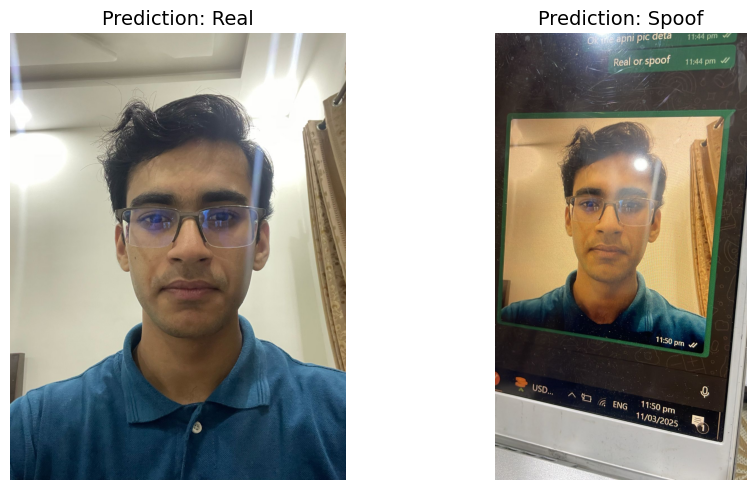

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification

# Load pre-trained model and processor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def preprocess_image(image_path):
    """Load, preprocess and return image tensor."""
    try:
        image = Image.open(image_path).convert("RGB")
        tensor = processor(image, return_tensors="pt")["pixel_values"]  # Shape: [1, 3, 224, 224]
        return image, tensor
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None, None

# Load and preprocess real & spoof images
real_image, real_tensor = preprocess_image("real.jpg")
spoof_image, spoof_tensor = preprocess_image("spoof.jpg")

# Ensure valid images were loaded
if real_tensor is None or spoof_tensor is None:
    print("Error: One or both images failed to load.")
    exit()

# Stack images into batch format
test_batch = torch.cat([real_tensor, spoof_tensor], dim=0).to(device)

# Run inference
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(test_batch)
    predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()  # Move predictions back to CPU

# Define labels
labels = {0: "Real", 1: "Spoof"}

# Print results
print(f"Real Photo Prediction: {labels[predictions[0]]}")
print(f"Spoof Photo Prediction: {labels[predictions[1]]}")

# 📸 **Display images with predictions**
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Real Image
axes[0].imshow(real_image)
axes[0].set_title(f"Prediction: {labels[predictions[0]]}", fontsize=14)
axes[0].axis("off")

# Spoof Image
axes[1].imshow(spoof_image)
axes[1].set_title(f"Prediction: {labels[predictions[1]]}", fontsize=14)
axes[1].axis("off")

# Show images
plt.tight_layout()
plt.show()


# **Q2**

# **Install Required Libraries**

In [ ]:
!pip install clip


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3qbz5lsd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3qbz5lsd
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


# **Download the COCO Dataset**

In [ ]:
import os
import urllib.request
import zipfile

# URLs for COCO dataset
coco_val_images_url = "http://images.cocodataset.org/zips/val2017.zip"
coco_annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

# Paths
coco_dir = "./coco"
val_images_path = os.path.join(coco_dir, "val2017.zip")
annotations_path = os.path.join(coco_dir, "annotations.zip")

# Create directory
os.makedirs(coco_dir, exist_ok=True)

# Function to download and extract files
def download_and_extract(url, save_path, extract_to):
    if not os.path.exists(extract_to):
        print(f"Downloading {url}...")
        urllib.request.urlretrieve(url, save_path)
        print(f"Extracting {save_path}...")
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(coco_dir)
        print(f"Extracted to {extract_to}")

# Download and extract COCO dataset
download_and_extract(coco_val_images_url, val_images_path, "./coco/val2017/")
download_and_extract(coco_annotations_url, annotations_path, "./coco/annotations/")


# **Load the CLIP-ViT Model**

In [ ]:
import torch
import clip  # Assuming you have 'clip' installed correctly
from PIL import Image
import torchvision.transforms as transforms

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)  # Use clip.load to load the model

# Load image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.481, 0.457, 0.408), (0.268, 0.261, 0.275))
])

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 162MiB/s]


# **Load COCO Annotations**

In [ ]:
import json

# Load COCO annotations
with open("./coco/annotations/captions_val2017.json", "r") as f:
    coco_data = json.load(f)

# Extract image IDs and captions
image_captions = {}
for ann in coco_data["annotations"]:
    image_id = ann["image_id"]
    caption = ann["caption"]
    if image_id not in image_captions:
        image_captions[image_id] = []
    image_captions[image_id].append(caption)

# Extract image file names
image_files = {img["id"]: img["file_name"] for img in coco_data["images"]}

print(f"Loaded {len(image_files)} images and {len(image_captions)} captions.")


Loaded 5000 images and 5000 captions.


# **Encode Images and Text Using CLIP**

In [ ]:
import os
import numpy as np
from tqdm import tqdm

# Function to encode images using CLIP
def encode_images(image_paths):
    image_features = []
    image_ids = []

    for image_id, file_name in tqdm(image_paths.items(), desc="Encoding Images"):
        img_path = os.path.join("./coco/val2017", file_name)
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        with torch.no_grad():
            img_feature = model.encode_image(image).cpu().numpy()

        image_features.append(img_feature)
        image_ids.append(image_id)

    return np.vstack(image_features), image_ids

# Encode all COCO validation images
image_features, image_ids = encode_images(image_files)


Encoding Images: 100%|██████████| 5000/5000 [20:44<00:00,  4.02it/s]


# **Retrieve Top-5 Similar Images for a Query**

In [ ]:
import torch.nn.functional as F

# Function to retrieve top-k similar images for a given text query
def retrieve_similar_images(query, image_features, image_ids, top_k=5):
    # Encode the text query
    text_inputs = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs).cpu().numpy()

    # Compute cosine similarity
    similarities = np.dot(image_features, text_features.T).squeeze(1)
    top_indices = similarities.argsort()[-top_k:][::-1]  # Get top-k indices

    # Retrieve corresponding image IDs and similarity scores
    top_images = [(image_ids[i], similarities[i]) for i in top_indices]

    return top_images

# Example query
query_text = "A person riding a bicycle"
top_results = retrieve_similar_images(query_text, image_features, image_ids)

# Print results
for rank, (image_id, score) in enumerate(top_results, 1):
    print(f"Rank {rank}: Image ID {image_id}, Similarity Score: {score:.4f}")


Rank 1: Image ID 210299, Similarity Score: 31.6279
Rank 2: Image ID 224051, Similarity Score: 31.1442
Rank 3: Image ID 380706, Similarity Score: 30.8568
Rank 4: Image ID 38829, Similarity Score: 30.1545
Rank 5: Image ID 144333, Similarity Score: 30.1212


# **Display Retrieved Images**

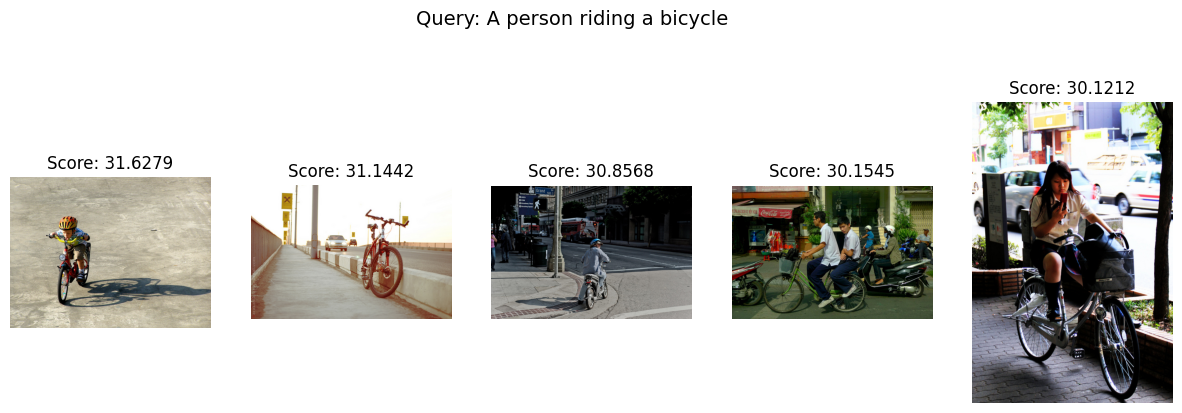

In [ ]:
import matplotlib.pyplot as plt

# Function to display top retrieved images
def display_results(query, top_images):
    fig, axes = plt.subplots(1, len(top_images), figsize=(15, 5))
    fig.suptitle(f"Query: {query}", fontsize=14)

    for idx, (image_id, score) in enumerate(top_images):
        img_path = os.path.join("./coco/val2017", image_files[image_id])
        img = Image.open(img_path)

        axes[idx].imshow(img)
        axes[idx].set_title(f"Score: {score:.4f}")
        axes[idx].axis("off")

    plt.show()

# Display results
display_results(query_text, top_results)


# **Q3:Stable Diffusion**

In [ ]:
!pip install torch torchvision diffusers transformers accelerate matplotlib pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

# Load the pre-trained model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker%2Fconfig.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def generate_variation(init_image_path, prompt, strength=0.75, guidance_scale=7.5, num_inference_steps=50):
    # Load the input image
    init_image = Image.open(init_image_path).convert("RGB")
    init_image = init_image.resize((512, 512))  # Resize to match Stable Diffusion's input size

    # Generate image variation
    image = pipe(
        prompt=prompt,
        image=init_image,
        strength=strength,  # Controls how much the output deviates from the input
        guidance_scale=guidance_scale,  # Higher values make the output follow the prompt more
        num_inference_steps=num_inference_steps  # More steps improve quality but increase computation
    ).images[0]

    return image


# **Experiment with different Parameters**

  0%|          | 0/10 [00:00<?, ?it/s]

Generated variation_1.png with {'strength': 0.5, 'guidance_scale': 5.0, 'num_inference_steps': 20}


  0%|          | 0/22 [00:00<?, ?it/s]

Generated variation_2.png with {'strength': 0.75, 'guidance_scale': 7.5, 'num_inference_steps': 30}


  0%|          | 0/45 [00:00<?, ?it/s]

Generated variation_3.png with {'strength': 0.9, 'guidance_scale': 12.0, 'num_inference_steps': 50}


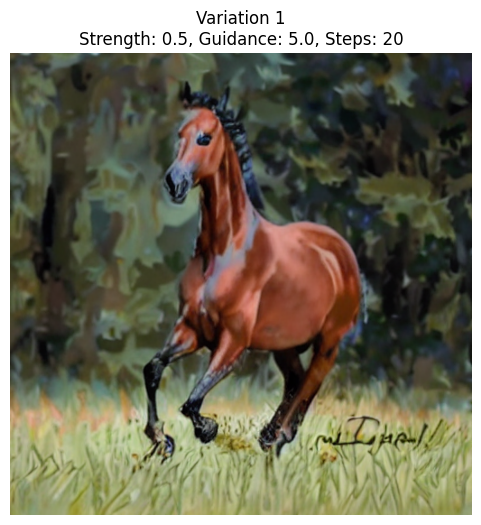

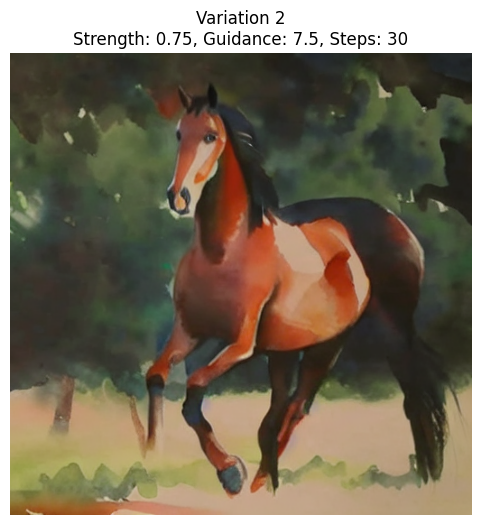

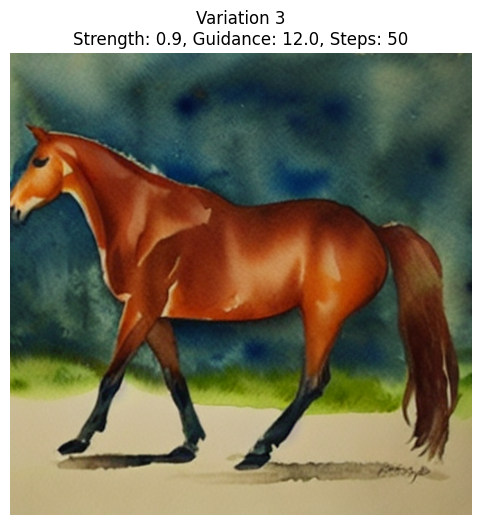

In [ ]:
import matplotlib.pyplot as plt
from diffusers import StableDiffusionImg2ImgPipeline
import torch
from PIL import Image

# Define input image
input_image_path = "download.jpg"  # Replace with actual path
init_image = Image.open(input_image_path).convert("RGB")
init_image = init_image.resize((512, 512))  # Resize for better performance

# Define a single prompt
prompt = "A watercolor painting of a horse"

# Define different parameter sets
params = [
    {"strength": 0.5, "guidance_scale": 5.0, "num_inference_steps": 20},
    {"strength": 0.75, "guidance_scale": 7.5, "num_inference_steps": 30},
    {"strength": 0.9, "guidance_scale": 12.0, "num_inference_steps": 50},
]

# Generate, save, and display each image separately
output_images = []  # Store images for batch display later

for i, param in enumerate(params):
    output_image = pipe(
        prompt=prompt,
        image=init_image,
        strength=param["strength"],
        guidance_scale=param["guidance_scale"],
        num_inference_steps=param["num_inference_steps"]
    ).images[0]

    # Save the image
    filename = f"variation_{i+1}.png"
    output_image.save(filename)
    print(f"Generated {filename} with {param}")

    # Store output image for later display
    output_images.append((output_image, param))

# Display all variations in a loop
for i, (output_image, param) in enumerate(output_images):
    plt.figure(figsize=(6, 6))
    plt.imshow(output_image)
    plt.axis("off")
    plt.title(f"Variation {i+1}\nStrength: {param['strength']}, Guidance: {param['guidance_scale']}, Steps: {param['num_inference_steps']}")
    plt.show()


# **Prompt Engineering & Analysis with 5 Prompts**

  0%|          | 0/37 [00:00<?, ?it/s]

Generated prompt_variation_1.png for prompt: 'A watercolor painting of a horse'


  0%|          | 0/37 [00:00<?, ?it/s]

Generated prompt_variation_2.png for prompt: 'A pixel art representation of a horse'


  0%|          | 0/37 [00:00<?, ?it/s]

Generated prompt_variation_3.png for prompt: 'A surreal horse painting in the style of Salvador Dalí'


  0%|          | 0/37 [00:00<?, ?it/s]

Generated prompt_variation_4.png for prompt: 'A horse painting in the style of Van Gogh'


  0%|          | 0/37 [00:00<?, ?it/s]

Generated prompt_variation_5.png for prompt: 'A futuristic cyberpunk horse with neon lights'


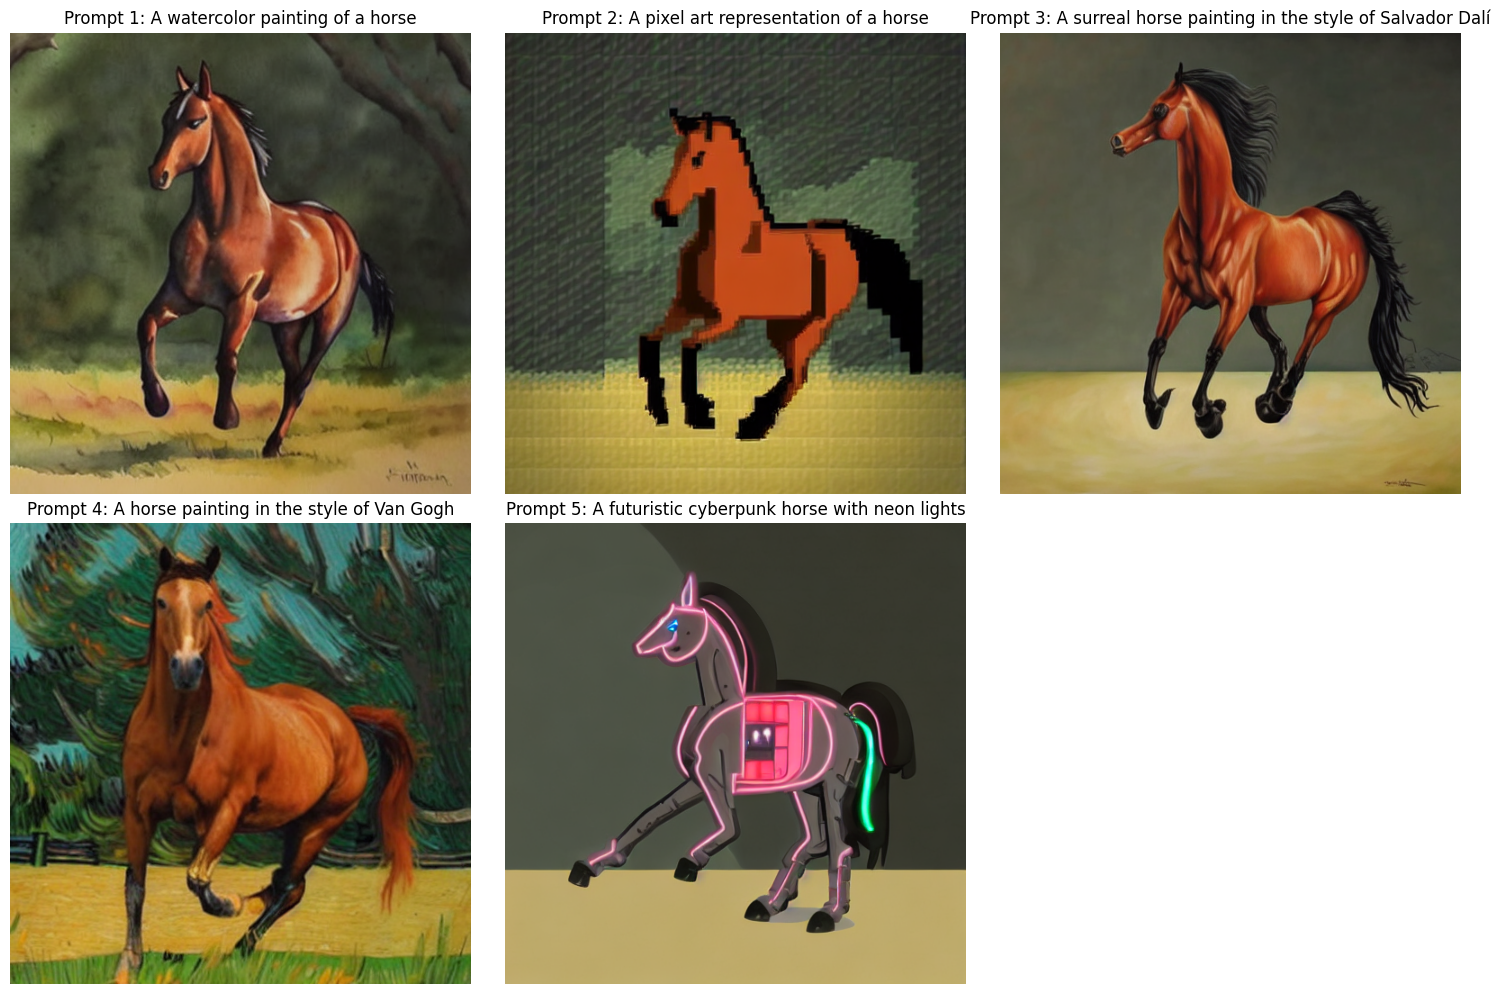

In [ ]:

# Define input image
input_image_path = "download.jpg"  # Replace with actual path
init_image = Image.open(input_image_path).convert("RGB")
init_image = init_image.resize((512, 512))  # Resize for better performance

# Define different prompts
prompts = [
    "A watercolor painting of a horse",
    "A pixel art representation of a horse",
    "A surreal horse painting in the style of Salvador Dalí",
    "A horse painting in the style of Van Gogh",
    "A futuristic cyberpunk horse with neon lights"
]

# Consistent parameter set for all prompts
param = {"strength": 0.75, "guidance_scale": 7.5, "num_inference_steps": 50}

# Generate, save, and store images
output_images = []

for i, prompt in enumerate(prompts):
    output_image = pipe(
        prompt=prompt,
        image=init_image,
        strength=param["strength"],
        guidance_scale=param["guidance_scale"],
        num_inference_steps=param["num_inference_steps"]
    ).images[0]

    # Save the image
    filename = f"prompt_variation_{i+1}.png"
    output_image.save(filename)
    print(f"Generated {filename} for prompt: '{prompt}'")

    # Store output image for later display
    output_images.append((output_image, prompt))

# Display all variations in a loop
plt.figure(figsize=(15, 10))

for i, (output_image, prompt) in enumerate(output_images):
    plt.subplot(2, 3, i + 1)
    plt.imshow(output_image)
    plt.axis("off")
    plt.title(f"Prompt {i+1}: {prompt}")

plt.tight_layout()
plt.show()
